In [1]:
# module imports
import pandas as pd
from pathlib import Path

In [2]:
# Find all files in the "Clean Datasets" folder that is csv
files = Path('./Clean Datasets').glob('*.csv')
# Initiate blank dataframe
df = pd.DataFrame()

# Iterate through all found csvs from clean datasets folder
for file in files:
    # Make sure not to combine country climate disasters as this is used for another metric
    if str(file).find('country_climate_disasters_clean') < 1:
        # read csv file
        curr_df = pd.read_csv(file)

        # check if dataframe is empty
        if df.empty:
            # set dataframe to current dataframe
            df = curr_df
        else:
            # merge dataframe on Year bind as inner
            df = df.merge(curr_df, on='Year', how='inner')

# Drop bias columns that is part of the target predictor TOTAL
df.drop(columns=['Drought', 'Extreme temperature', 'Flood', 'Landslide', 'Storm', 'Wildfire'], inplace=True)
# Replace NAs with the mean of the column
df.fillna(df.mean(), inplace=True)
# describe dataframe
df.describe()

,Year,TOTAL,CO PPM,CO Percent,Carbon stocks in forests,Forest area,Index of carbon stocks in forests,Index of forest extent,Land area,Share of forest area,...,Vanuatu,"Venezuela, Rep. Bolivariana de",Vietnam,Wallis and Futuna Islands,West Bank and Gaza,Western Sahara,World_y,"Yemen, Rep. of",Zambia,Zimbabwe
count,29.000000,29.000000,29.000000,29.000000,29.000000,2.900000e+01,29.000000,29.000000,2.900000e+01,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,2.900000e+01,29.000000,29.000000
mean,2006.000000,304.551724,382.818563,0.526897,294855.059428,4.131409e+06,99.294906,97.883128,1.300968e+07,31.756821,...,0.578517,0.764517,0.710172,0.602414,0.734517,1.313276,0.981345,1.070000e-01,0.652517,0.320586
std,8.514693,61.330246,17.615761,0.150010,928.749340,4.760892e+04,0.312764,1.127971,1.423159e+04,0.399391,...,0.345287,0.279873,0.452479,0.411114,0.684435,0.411943,0.365750,4.237029e-17,0.396632,0.451548
min,1992.000000,167.000000,356.545833,0.187500,293654.725000,4.058927e+06,98.890683,96.165863,1.298901e+07,31.159624,...,-0.281000,0.298000,0.001000,-0.307000,-1.045000,0.315000,0.184000,1.070000e-01,-0.117000,-0.417000
25%,1999.000000,287.000000,368.540000,0.463333,294194.582900,4.092844e+06,99.072485,96.969426,1.299595e+07,31.421353,...,0.402000,0.545000,0.332000,0.361000,0.519000,0.942000,0.834000,1.070000e-01,0.362000,0.004000
50%,2006.000000,314.000000,382.090833,0.522500,294551.667100,4.127010e+06,99.192736,97.778913,1.301345e+07,31.709619,...,0.573000,0.760000,0.722000,0.686000,0.735000,1.356000,0.993000,1.070000e-01,0.711000,0.232000
75%,2013.000000,354.000000,396.737500,0.605833,295374.528800,4.165888e+06,99.469841,98.700026,1.302568e+07,32.060031,...,0.777000,0.933000,1.043000,0.827000,1.043000,1.510000,1.195000,1.070000e-01,0.891000,0.685000
max,2020.000000,407.000000,414.210833,0.849167,296948.829100,4.220757e+06,100.000000,100.000000,1.302696e+07,32.490001,...,1.226000,1.350000,1.811000,1.379000,2.326000,2.204000,1.711000,1.070000e-01,1.450000,1.270000


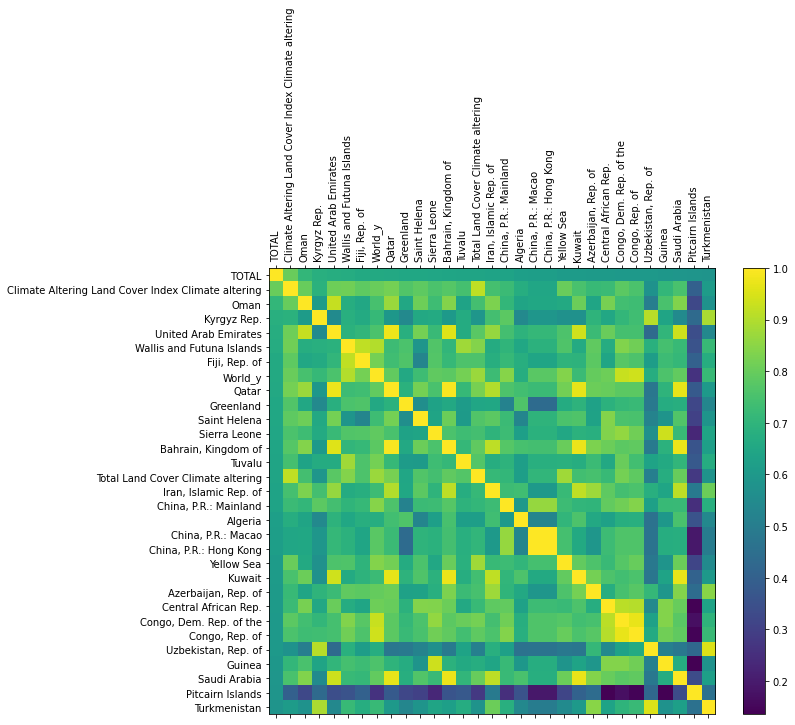

In [3]:
# import visual package matplotlib
import matplotlib.pyplot as plt

# Find top 30 correlated features to the predictor TOTAL and get the column names
corr_cols = df.drop(columns=['Year']).corr().loc[:,['TOTAL']].dropna().sort_values(by=['TOTAL'], ascending=False, axis=0).head(31).T.columns.tolist()

# Plot correlation of the top 30 correlated features including TOTAL
plt.figure(figsize=(10, 8))
plt.matshow(df.loc[:, corr_cols].corr(), fignum=1)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)

plt.colorbar()
plt.show()